# Train `LightGBM` on the output of the `fastText` model

In [1]:
import pylab as p
from numpy import *
import pandas as pd
from tqdm import tqdm
import lightgbm as lgbm
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import log_loss as skl_log_loss
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score as skl_roc_auc_score

### Custom functions

In [2]:
def my_log_loss(ytrue, ypred):
    ll = zeros(6)
    for i in range(6):
        ll[i] = skl_log_loss(ytrue[:,i], ypred[:,i])
    return ll.mean()

def evalroc(preds, dtrain):
    
    labels = dtrain.get_label()
    
    return 'roc', - skl_roc_auc_score(labels, preds)

# def lr_decay(i, itotal):
#     if (i<=10):
#         lr = 0.2
#     elif (10<i) & (i<=100):
#         lr = 0.1
#     elif (100<i) & (i<=300):
#         lr = 0.05
#     elif (300<i) & (i<=500):
#         lr =  0.01
#     elif (500<i) & (i<=1000):
#         lr = 0.005
#     else:
#         lr = 0.001

#     return lr

def lr_decay(i):
    start_lr = 0.2
    if (i<=10):
        lr = 0.2
    elif (10<i) & (i<=20):
        lr = 0.1
    else:
        lr = start_lr * (1./(1+0.1*i))
        
    return lr

### Read in the original data

In [3]:
# Read in the TOXIC competition data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Target labels
ycols = train.columns[2:]
ys = train[ycols].values

# Read in the fastText predictions
X = pd.read_csv('./ft_train_features_avg.csv.bz2')
Y = pd.read_csv('./ft_test_features_avg.csv.bz2')

print('Reading the challenge data...')
print( '%-27s %-10i' % ('Size of the training set:', len(train)))
print( '%-27s %-10i' % ('Size of the testing set:', len(test)))
print()

Reading the challenge data...
Size of the training set:   159571    
Size of the testing set:    153164    



### The optimization process

In [ ]:
%%time

def lgbm_cv_eval(max_depth, subsample, colsample_bytree, reg_lambda, reg_alpha, min_data_in_leaf):

    params = {
        'boosting': 'gbdt',
        'max_depth': int(round(max_depth)),
        'learning_rate': 0.2,
        'num_leaves': 31,
        'application': 'binary',
        'metric': 'binary_logloss',
        'num_threads': 12,
        'min_data_in_leaf': int(round(min_data_in_leaf)),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha,
    }
    
    # The generator for the KFolds
    kf = KFold(n_splits=8, shuffle=False, random_state=None)
    

    # Do the x-validation
    cv_result = lgbm.cv(params=params, 
                        train_set=dtrain, 
                        num_boost_round=500, 
                        folds=kf.split(X), 
                        stratified=False, 
                        shuffle=False, 
                        verbose_eval=False,
                        callbacks=[lgbm.callback.reset_parameter(learning_rate=lr_decay)],
                        metrics=('auc','binary_logloss'), early_stopping_rounds=31)
    
    # Return the metric to be maximized
    return cv_result['auc-mean'][-1]

### The cycle starts here
best_params={}
best_roc={}

for i,v in enumerate(ycols):
    print('Optimizing label:', v)
    dtrain = lgbm.Dataset(data=X, label=ys[:,i])
    
    # The Bayesian Optimizer
    optimizer = BayesianOptimization(lgbm_cv_eval, {'max_depth': (3, 15),
                                                    'subsample': (0.3, 1),
                                                    'colsample_bytree': (0.3, 1),
                                                    'reg_lambda': (0, 10),
                                                    'reg_alpha': (0, 10),
                                                    'min_data_in_leaf': (20, 500),
                                                  },
                                     verbose=0)
    # This is doing the optimization
    optimizer.maximize(init_points=5, n_iter=310)
    
    # Save the best params and the best roc value found 
    best_params[v] = optimizer.res['max']['max_params']
    best_roc[v] = optimizer.res['max']['max_val']
    print('Best roc:', optimizer.res['max']['max_val'])
    print('')

Optimizing label: toxic


/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.50357373e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.35757975e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00026818]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.07761511e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03360839]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/minicond

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00552094]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00286871]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0001067]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00064631]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00042778]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00349553]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 95, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/li

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0005244]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01445025]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00316739]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03412008]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.04776041]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.02587832]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/li

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00013618]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00017023]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 91, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00035051]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/l

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([7.60406256e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00012651]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.39362658e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/minic

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00024796]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.93364239e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 79, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.03020433]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0020144]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00892611]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0058443]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 99, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/p

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0006357]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 90, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00130314]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00774047]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
/net/baade/data/users/jovan/miniconda3/lib

/net/baade/data/users/jovan/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.02226633]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 93, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)


### The `LightGBM' model

In [18]:
# My own lgbm model class, useful for training stuff on the fly, with x-validations and all

class lgbm_model():
    def __init__(self, X, label, Y):
        '''
        params:
        X     = sparse matrix csr format (training set)
        label = 1-d array, same length as X, the target value
        Y     = sparse matrix csr format (test set)
        '''
        self.X     = X
        self.label = label
        self.Y     = Y
    
    def run_lgbm_model(self, params, num_boost_round, num_folds=5, verbose_eval=False, show_plot=True):
        
        # The KFold object
        kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
        
        # The history for the plots
        hh = tmp = [{} for _ in range(num_folds)]
        
        # metrics
        val_loss = zeros(num_folds)
        val_roc = zeros(num_folds)
        
        # predictions on the validation set
        vvpred = zeros(num_folds, dtype='O')
        
        # The test results predictions from each fold
        pred = zeros((num_folds, 153164))
        
        # The training the KFold x-validation starts here
        for i, (ind_train, ind_val) in enumerate(kf.split(self.X)):
            XX, VV = self.X[ind_train], self.X[ind_val]
            yx, yv = self.label[ind_train], self.label[ind_val]
            
            # Convert the training and validation set into the lgbm format
            dtrain = lgbm.Dataset(data=XX, label=yx)
            dval   = lgbm.Dataset(data=VV, label=yv)
            
            # The booster model for the given data
            booster = lgbm.train(params=params, 
                                 train_set=dtrain, 
                                 num_boost_round=num_boost_round, 
                                 valid_sets=[dtrain,dval],
                                 valid_names=['train','val'],
                                 evals_result=hh[i],
                                 learning_rates=self.lr_decay,
                                 early_stopping_rounds=31,
                                 verbose_eval=verbose_eval)
            
            
            # Predictions on the validation set
            vvpred[i] = booster.predict(VV)
                        
            # Record the metrics
            val_loss[i] = skl_log_loss(yv, vvpred[i])
            val_roc[i] = skl_roc_auc_score(yv, vvpred[i])
            
            # Predictions onthe test set
            pred[i] = booster.predict(self.Y)

        # Plot the loss function as a diagnostic
        if show_plot:
            p.figure(figsize=(9,6))
            for i in range(num_folds):
                p.plot((hh[i]['train']['binary_logloss']), lw=2, ls='solid')
                p.plot((hh[i]['val']['binary_logloss']), lw=2, ls='dashed')
            p.show()
        
        # Collect the results
        print()
        print('Average logloss across the x-validation folds: %2.6f' % (val_loss.mean()))
        print('Average roc-auc across the x-validation folds: %2.6f' % (val_roc.mean()))
        
        # Stack the predictions from the validation and test sets
        vvpred = hstack(vvpred)
        pred = pred.mean(axis=0)
        
        return vvpred, pred

    def lr_decay(self, i):
        start_lr = 0.2
        if (i<=10):
            lr = 0.2
        elif (10<i) & (i<=20):
            lr = 0.1
        else:
            lr = start_lr * (1./(1+0.1*i))

        return lr

Predicting toxic comments


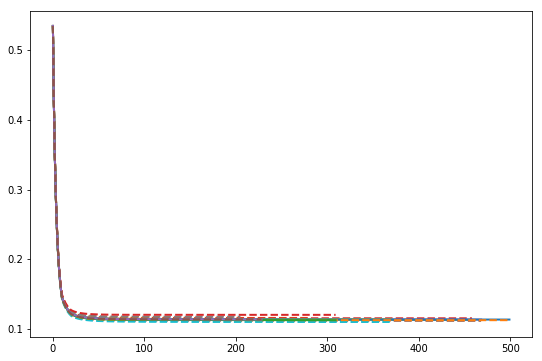


Average logloss across the x-validation folds: 0.114250
Average roc-auc across the x-validation folds: 0.955255


Predicting severe_toxic comments


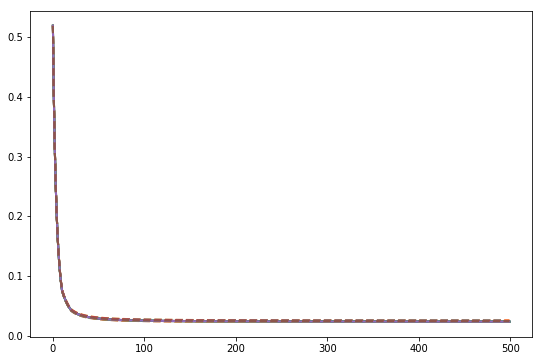


Average logloss across the x-validation folds: 0.024179
Average roc-auc across the x-validation folds: 0.985879


Predicting obscene comments


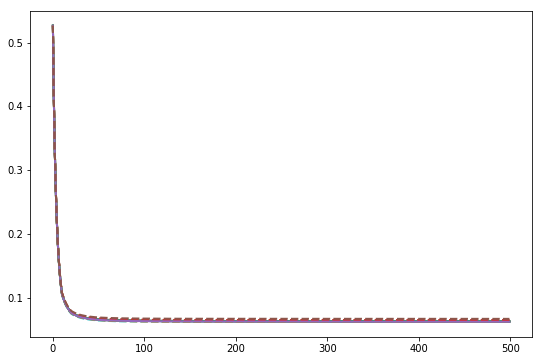


Average logloss across the x-validation folds: 0.063881
Average roc-auc across the x-validation folds: 0.978832


Predicting threat comments


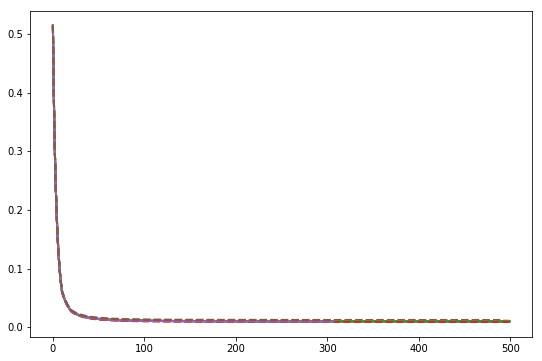


Average logloss across the x-validation folds: 0.010453
Average roc-auc across the x-validation folds: 0.956805


Predicting insult comments


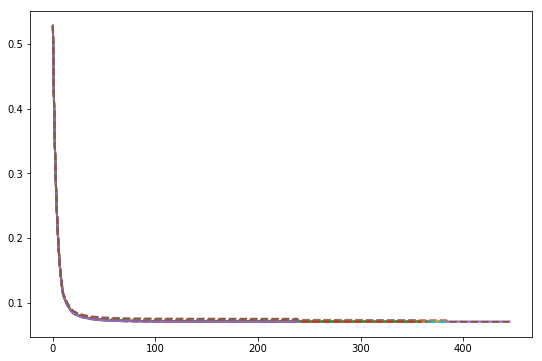


Average logloss across the x-validation folds: 0.072273
Average roc-auc across the x-validation folds: 0.972147


Predicting identity_hate comments


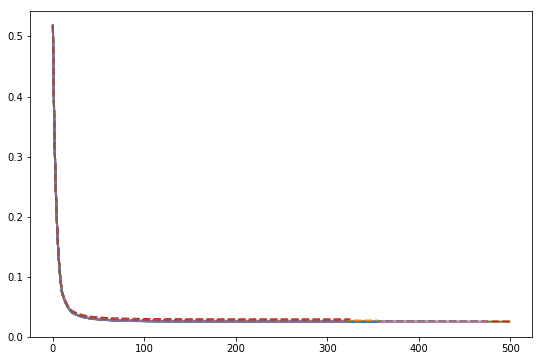


Average logloss across the x-validation folds: 0.027309
Average roc-auc across the x-validation folds: 0.956039


CPU times: user 19min 11s, sys: 14.1 s, total: 19min 25s
Wall time: 1min 37s


In [19]:
%%time

# This cell runs the lgbm_model stacking the outputs of the different models

# The parameters for the training process
params = {
    'boosting': 'gbdt',
    'max_depth': 7,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'application': 'binary',
    'metric': 'binary_logloss',
    'num_threads': 12,
    'min_data_in_leaf': 20,
    'subsample': 0.80,
    'colsample_bytree': 0.80,
    'reg_lambda': 0.5,
    'reg_alpha': 1.5,
}

# This is where the outputs are stored
vvpred = zeros((X.shape[0], len(ycols)))
pred   = zeros((Y.shape[0], len(ycols)))

for i,v in enumerate(ycols):
    # update the parameters for the best parameters from the optimization process
    for j,w in enumerate(best_params[v].keys()):
        if (w=='max_depth') or (w=='min_data_in_leaf') :
            params[w] = round(int(best_params[v][w]))
        else:
            params[w] = best_params[v][w]
    # Predicting the comments
    print('Predicting %s comments' % (v))
    # instantiating my own lgbm_model class
    booster = lgbm_model(X=X.values, label=ys[:,i],  Y=Y.values)
    vvpred[:,i], pred[:,i] = booster.run_lgbm_model(params=params, num_boost_round=500, num_folds=8)
    print('')
    print('')


### Save the final results to disk

In [20]:
### Save the results to disk, ready for submission
# Creating data frames for convenience
df_train = pd.DataFrame(vvpred, columns='FT'+ycols)
df_test = pd.DataFrame(pred, columns='FT'+ycols)
# Save them to disk 
df_train.to_csv('./results/lgbm_fasttext_train.csv.bz2', index=False, compression='bz2')
df_test.to_csv('./results/lgbm_fasttext_test.csv.bz2', index=False, compression='bz2')
# Save a submission file, for testing on the lb right away
submission = pd.read_csv('../sample_submission.csv')
submission[ycols] = pd.DataFrame(pred, columns=ycols)
submission.to_csv('./results/lgbm_fasttext_submission.csv', index=False)